In [1]:
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=4,suppress=True)

A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
D = Jacobi.operator('D')
Z = Jacobi.operator('Z')
Id = Jacobi.operator('Id')


In [2]:
n, a, b = 6, -1/2, -1/2

# Derivative of Chebyshev: d/dz T_n -> n U_{n-1}
print(D(+1)(n, a, b).todense())

# Convert Chebyshev: T_n = 1/2*(U_n - U_{n-2})
print((A(+1) @ B(+1))(n, a, b).todense())


[[0. 1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 4. 0.]
 [0. 0. 0. 0. 0. 5.]]
[[ 0.7071  0.     -0.5     0.      0.      0.    ]
 [ 0.      0.5    -0.     -0.5     0.      0.    ]
 [ 0.      0.      0.5     0.     -0.5     0.    ]
 [ 0.      0.      0.      0.5    -0.     -0.5   ]
 [ 0.      0.      0.      0.      0.5     0.    ]
 [ 0.      0.      0.      0.      0.      0.5   ]]


In [3]:
# Conversion operators
n, a, b = 6, -1/2, -1/2
z = np.linspace(-1,1,2000)
Tn = Jacobi.polynomials(n,a,  b,  z).T
Un = Jacobi.polynomials(n,a+1,b+1,z).T

# E acts on basis polynomials from the right to convert from
# Chebyshev U to Chebyshev T
E = (A(+1) @ B(+1))(n, a, b)
Tnp = Un @ E
assert np.max(abs(Tn-Tnp)) < 1e-14

# Express our polynomial as a sum of Chebyshev T coefficients,
# then convert them to coefficients for Chebyshev U polynomials
cT = ((n-np.arange(n))/n)**2
cU = E @ cT
assert np.max(abs(Tn @ cT - Un @ cU)) < 1e-13


In [7]:
# Quadrature nodes
n, a, b = 15, -1/2, -1/2
z, w = Jacobi.quadrature(n,a,b)
q = -np.cos((np.arange(n)+1/2)*np.pi/n)

assert np.max(abs(z-q)) < 1.3e-15

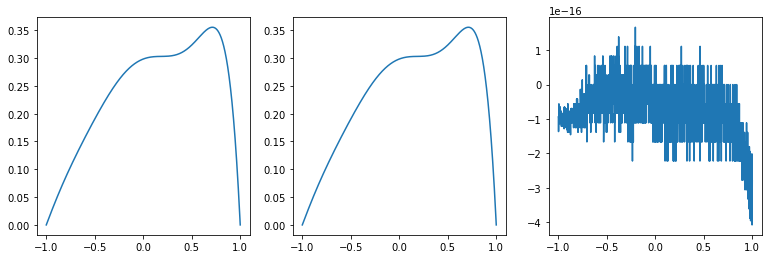

In [8]:
# Multiply by 1-z^2
n, a, b = 6, -1/2, -1/2
z = np.linspace(-1,1,2000)
Tn = Jacobi.polynomials(n+2,a,b,z).T

# (1-z**2) <n,a,b,z> -> <n+2,a,b,z| Z
# Convert to Chebyshev U so that we can apply 1-z**2 = (1-z)*(1+z),
# which raises n->n+2 and lowers a,b -> a-1,b-1.
# Multiplying by 1-z**2 is accomplished with a non-square, n+2 x n
# matrix.  When we construct our full system we'll have to deal with this,
# probably just by truncating since we hope we're well-enough resolved
# (insert tau error equivalence argument)
Zz = ((A(-1) @ B(-1)) @ (A(+1) @ B(+1)))(n, a, b)

c = ((n-np.arange(n))/n)**2
f = Tn[:,:-2] @ c
fz = (1-z**2)*f
fz2 = Tn @ Zz @ c
error = fz-fz2

assert np.max(abs(error)) < 1e-15

fig, plot_axes = plt.subplots(1,3,figsize=[13,4])
plot_axes[0].plot(z,fz)
plot_axes[1].plot(z,fz2)
plot_axes[2].plot(z,error)

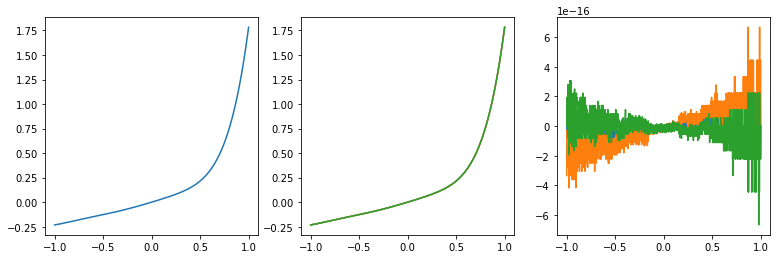

In [9]:
# Multiply by z
n, a, b = 6, -1/2, -1/2
z = np.linspace(-1,1,2000)
Tn = Jacobi.polynomials(n+1,a,b,z).T

Zz = Jacobi.operator('Z')(n,a,b)   # Built-in operator using both a,b incrememnts
Za = (Id - A(-1) @ A(+1))(n,a,b)  # Multiply by z using a increments alone
Zb = (B(-1) @ B(+1) - Id)(n,a,b)  # Multiply by z using b increments alone

c = ((n-np.arange(n))/n)**2
f = Tn[:,:-1] @ c

fzgrid = z*f
fz = Tn @ Zz @ c
fza = Tn @ Za @ c
fzb = Tn @ Zb @ c
error = fzgrid - fz
errora = fzgrid - fza
errorb = fzgrid - fzb

assert np.max(abs(error)) < 1e-15
assert np.max(abs(errora)) < 1e-15
assert np.max(abs(errorb)) < 1e-15

fig, plot_axes = plt.subplots(1,3,figsize=[13,4])
plot_axes[0].plot(z,fz)
plot_axes[1].plot(z,fz)
plot_axes[1].plot(z,fza)
plot_axes[1].plot(z,fzb)
plot_axes[2].plot(z,error)
plot_axes[2].plot(z,errora)
plot_axes[2].plot(z,errorb)

In [10]:
# Some differential operators
n, a, b = 6, -1/2, -1/2
z = np.linspace(-1,1,20000)

Pn = Jacobi.polynomials(n,a,b,z).T
c = ((n-np.arange(n))/n)**2
f = Pn @ c

# d/dz
op = D(+1)
fgrid = (f[2:]-f[:-2])/(z[2:]-z[:-2])
Pn = Jacobi.polynomials(n-1,a+1,b+1,z).T
fcoeff = Pn @ op(n,a,b) @ c
fcoeff = fcoeff[1:-1]
assert np.max(abs(error)) < 3e-7

# z*d/dz
op = Jacobi.operator('Z') @ D(+1)
fgrid = z[1:-1]*(f[2:]-f[:-2])/(z[2:]-z[:-2])
Pn = Jacobi.polynomials(n,a+1,b+1,z).T
fcoeff = Pn @ op(n,a,b) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-7

# d^2/dz^2
op = D(+1) @ D(+1)
fgrid = 4*(f[2:]-2*f[1:-1]+f[:-2])/(z[2:]-z[:-2])**2
Pn = Jacobi.polynomials(n-2,a+2,b+2,z).T
fcoeff = Pn @ op(n,a,b) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 3e-7


In [11]:
# Legendre polynomial relation 
#   (ell+1) P_{ell} + z d/dz( P_{ell} ) = sqrt((2*ell+1)/(2*ell+3)) * d/dz( P_{ell+1} )
#                                       = alpha_{ell} * (ell+2)/2 P_{ell}^(1,1),
# where alpha_{ell} is the norm ratio ||P_{ell}^(1,1)|| / ||P_{ell}^(0,0)||
n, a, b = 10, 0, 0
z = np.linspace(-1,1,2000)

Ln = Jacobi.polynomials(n,a,b,z).T
Pn = Jacobi.polynomials(n,a+1,b+1,z).T

N = Jacobi.operator('N')
op = ((A(+1) @ B(+1)) @ (N + Id) + Z @ D(+1))
lhs = Pn @ op(n,a,b)

# First identity
ell = np.arange(n)
alpha = Jacobi.norm_ratio(0,1,1,ell,a,b)
rhs = Pn @ np.diag(alpha) @ ((N + 2*Id)/2)(n,a+1,b+1)
assert np.max(abs(lhs-rhs)) < 6e-14


# Second identity
alpha = Jacobi.norm_ratio(1,0,0,ell,a,b)
Qn = Jacobi.polynomials(n+1,a+1,b+1,z).T
rhs = alpha * (Qn[:,:-1] @ D(+1)(n+1,a,b))[:,1:]
assert np.max(abs(lhs - rhs)) < 6e-14



In [15]:
print(op(8,0,0).todense())

[[ 0.      0.      4.899   0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     10.9545  0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.     18.9737  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.     28.9828  0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.     40.9878  0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.     54.9909]]


In [ ]:
print('Success!')